In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from DecisionTree import DecisionTree
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from BaggingClassifier import BaggingClassifier
%run DecisionTree.py


In [306]:
# Load dataset
data = pd.read_csv('heart.csv')
# Binary encoding for 'Sex' and 'ExerciseAngina'
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
# Extract features and labels
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

In [107]:
# One-Hot Encoding for non-binary categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = OneHotEncoder(sparse=False)

if categorical_cols:  # Only encode if there are categorical features
    encoded_array = encoder.fit_transform(X[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
    X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

X = X.to_numpy()
y = y.to_numpy()

d:\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#X_val (10%) → Used for hyperparameter tuning.
# X_test (20%) → Used for final evaluation.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp
)


In [11]:
# tune the hyperparameters of the DecisionTree model
max_depths = [5, 10, 15, 20, 25]
min_samples_splits = [2, 4, 6, 8, 10]

# Initialize best hyperparameters
best_max_depth = None
best_min_samples_split = None
best_accuracy = 0

# Tune hyperparameters
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        model = DecisionTree(max_depth=max_depth, min_sample_split=min_samples_split)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        if accuracy > best_accuracy:
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_accuracy = accuracy
            

In [15]:
# Train the DecisionTree model with the best hyperparameters
model = DecisionTree(max_depth=best_max_depth, min_sample_split=best_min_samples_split)
model.fit(X_train, y_train)

# get predictions and accuracy of the DecisionTree model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of DecisionTree: {accuracy}")

Accuracy of DecisionTree: 0.8152173913043478


In [111]:
# train sklearn's DecisionTreeClassifier
sklearn_model = DecisionTreeClassifier(random_state=42)
sklearn_model.fit(X_train, y_train)

# predict on validation set
val_set = sklearn_model.predict(X_val)
# compute accuracy
accuracy = accuracy_score(y_val, val_set)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8587


In [36]:
# Train the Bagging Classifier
bagging_model = BaggingClassifier(base_learner=DecisionTree, n_estimators=20)
bagging_model.fit(X_train, y_train)


use X_val to tune the model during training, and use X_test to evaluate the model after training.

In [37]:
# Predict using Bagging Classifier
val_set = bagging_model.predict(X_val)
# Compute accuracy
accuracy = accuracy_score(y_val, val_set)
print(f"Bagging Classifier Validation Accuracy: {accuracy:.4f}")


Bagging Classifier Validation Accuracy: 0.9022


Bagging Classifier evaluation

In [38]:
# Predict using Bagging Classifier
y_pred = bagging_model.predict(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


In [39]:
# Print accuracy and F1-score
print(f"Bagging Classifier Test Accuracy: {accuracy:.4f}")
print(f"Bagging Classifier F1-Score: {f1:.4f}")

Bagging Classifier Test Accuracy: 0.8913
Bagging Classifier F1-Score: 0.9000


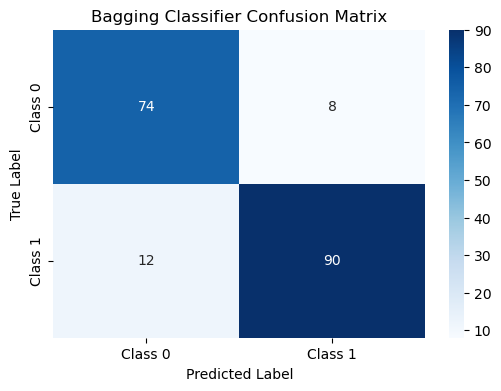

In [42]:
# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix, "Bagging Classifier Confusion Matrix")

In [113]:
# Training KNN model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
#  Hyperparameter Tuning
# --------------------------

k_values = [3, 5, 11]
distance_metrics = ['euclidean', 'manhattan']

best_val_accuracy = 0
best_k = None
best_metric = None
best_model = None

for k in k_values:
    for metric in distance_metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_scaled, y_train)
        
        # Predict on the validation set
        y_val_pred = knn.predict(X_val_scaled)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        print(f"k: {k}, metric: {metric}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Update best model if current model is better
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_k = k
            best_metric = metric
            best_model = knn

print("\nBest Hyperparameters:")
print(f"Best k: {best_k}")
print(f"Best distance metric: {best_metric}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# ---------------------------
# Evaluation on Test Set
# ---------------------------
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

k: 3, metric: euclidean, Validation Accuracy: 0.8696
k: 3, metric: manhattan, Validation Accuracy: 0.9239
k: 5, metric: euclidean, Validation Accuracy: 0.8913
k: 5, metric: manhattan, Validation Accuracy: 0.9022
k: 11, metric: euclidean, Validation Accuracy: 0.8913
k: 11, metric: manhattan, Validation Accuracy: 0.8913

Best Hyperparameters:
Best k: 3
Best distance metric: manhattan
Best Validation Accuracy: 0.9239
Test Accuracy: 0.8533


c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [114]:
# train logistic regression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# predict on validation set
val_set = logistic_model.predict(X_val)
# compute accuracy
accuracy = accuracy_score(y_val, val_set)

print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8913


c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Design Neural Network

# Scale Data and Convert to PyTorch Tensors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)          
X_val_scaled = scaler.transform(X_val)            

# Convert the scaled NumPy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  

x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Neural Network Definition
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, learning_rate, num_epochs):
        super(BinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.sigmoid(x)
        return x


def train_model(model, train_loader, val_loader):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=model.learning_rate)
    best_val_loss = float('inf')
    early_stopping_threshold = 5
    no_improve_epochs = 0

    for epoch in range(model.num_epochs):
        model.train()
        total_loss = 0
        for example, lab in train_loader:
            optimizer.zero_grad()
            output = model(example).squeeze()
            loss = criterion(output, lab.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_loss = validate_model(model, val_loader, criterion)

        print(f"Epoch [{epoch+1}/{model.num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_threshold:
            print(f"Early stopping at epoch {epoch+1}")
            break

def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for example, lab in val_loader:
            output = model(example).squeeze()
            loss = criterion(output, lab.float())
            total_loss += loss.item()
    return total_loss / len(val_loader)

def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for example, _ in test_loader:
            output = model(example).squeeze()
            predicted = (output >= 0.5).int()  # Threshold at 0.5 to decide between class 0 and 1
            predictions.extend(predicted.numpy())
    return predictions


In [98]:
# Tune Hyperparameters 
input_size = X_train.shape[1]
num_epochs = 100
hidden_sizes = [16, 32, 64, 128]
lr_values = [0.001, 0.01, 0.1]

best_hidden_size = None
best_lr = None
best_accuracy = 0

for hidden_size in hidden_sizes:
    
    for lr in lr_values:
        model = BinaryClassifier(input_size, hidden_size, lr, num_epochs)
        model.train()
        train_model(model, train_loader, val_loader)
        y_pred = predict(model, val_loader)
        accuracy = accuracy_score(y_val, y_pred)
        if accuracy > best_accuracy:
            best_hidden_size = hidden_size
            best_lr = lr
            best_accuracy = accuracy
            
print(f"Best Hidden Size: {best_hidden_size}")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch [1/100], Loss: 0.7248, Val Loss: 0.6960
Epoch [2/100], Loss: 0.7069, Val Loss: 0.6809
Epoch [3/100], Loss: 0.6756, Val Loss: 0.6663
Epoch [4/100], Loss: 0.6638, Val Loss: 0.6503
Epoch [5/100], Loss: 0.6433, Val Loss: 0.6331
Epoch [6/100], Loss: 0.6364, Val Loss: 0.6137
Epoch [7/100], Loss: 0.6229, Val Loss: 0.5938
Epoch [8/100], Loss: 0.6056, Val Loss: 0.5725
Epoch [9/100], Loss: 0.5701, Val Loss: 0.5499
Epoch [10/100], Loss: 0.5357, Val Loss: 0.5249
Epoch [11/100], Loss: 0.5137, Val Loss: 0.4992
Epoch [12/100], Loss: 0.4831, Val Loss: 0.4739
Epoch [13/100], Loss: 0.4746, Val Loss: 0.4499
Epoch [14/100], Loss: 0.4349, Val Loss: 0.4280
Epoch [15/100], Loss: 0.4100, Val Loss: 0.4067
Epoch [16/100], Loss: 0.4066, Val Loss: 0.3877
Epoch [17/100], Loss: 0.3940, Val Loss: 0.3718
Epoch [18/100], Loss: 0.4680, Val Loss: 0.3589
Epoch [19/100], Loss: 0.3998, Val Loss: 0.3528
Epoch [20/100], Loss: 0.3422, Val Loss: 0.3469
Epoch [21/100], Loss: 0.3504, Val Loss: 0.3397
Epoch [22/100], Loss: 

In [99]:
# Train the model with the best hyperparameters
model = BinaryClassifier(input_size, best_hidden_size, best_lr, num_epochs)
model.train()
train_model(model, train_loader, val_loader)

# Get predictions and accuracy of the model on the test set
y_pred = predict(model, test_loader)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Neural Network: {accuracy}")

Epoch [1/100], Loss: 0.7065, Val Loss: 0.6799
Epoch [2/100], Loss: 0.6511, Val Loss: 0.6497
Epoch [3/100], Loss: 0.6473, Val Loss: 0.6220
Epoch [4/100], Loss: 0.6119, Val Loss: 0.5970
Epoch [5/100], Loss: 0.5848, Val Loss: 0.5738
Epoch [6/100], Loss: 0.5405, Val Loss: 0.5494
Epoch [7/100], Loss: 0.5416, Val Loss: 0.5257
Epoch [8/100], Loss: 0.5057, Val Loss: 0.5041
Epoch [9/100], Loss: 0.4853, Val Loss: 0.4821
Epoch [10/100], Loss: 0.4814, Val Loss: 0.4611
Epoch [11/100], Loss: 0.4367, Val Loss: 0.4439
Epoch [12/100], Loss: 0.4279, Val Loss: 0.4269
Epoch [13/100], Loss: 0.4249, Val Loss: 0.4110
Epoch [14/100], Loss: 0.3871, Val Loss: 0.3967
Epoch [15/100], Loss: 0.4050, Val Loss: 0.3845
Epoch [16/100], Loss: 0.3603, Val Loss: 0.3750
Epoch [17/100], Loss: 0.3621, Val Loss: 0.3660
Epoch [18/100], Loss: 0.3385, Val Loss: 0.3587
Epoch [19/100], Loss: 0.3366, Val Loss: 0.3520
Epoch [20/100], Loss: 0.3507, Val Loss: 0.3450
Epoch [21/100], Loss: 0.3811, Val Loss: 0.3382
Epoch [22/100], Loss: 

In [100]:
# evaluate using Conufusion Matrix and f1 score
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[69 13]
 [10 92]]
F1 Score: 0.8889
